### Surface heat budget: MOM vs. CPL
This notebooks compares the yearly averages from the MOM6 history file agains the budget table generated by the coupler.


In [19]:
from mom6_tools.DiagsCase import DiagsCase
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.m6toolbox import genBasinMasks

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mom6_tools.m6plot import xyplot
import warnings, os, yaml

In [20]:
diag_config_yml = yaml.load(open('diag_config_comparison.yml','r'),
                            Loader=yaml.Loader)

In [21]:
# initialize lists
dcase = []; casename=[]
label = []; outdir=[]
ocn_path = []
ncases = len(diag_config_yml.keys()) - 1
if ncases < 2:
  # Create the case instance
  dcase = DiagsCase(diag_config_yml['Case'], xrformat=True)
  casename.append(dcase.casename)
  label.append(diag_config_yml['Case']['SNAME'])
  ocn_path.append(diag_config_yml['Case']['OCN_DIAG_ROOT'])
  DOUT_S = dcase.get_value('DOUT_S')
  if DOUT_S:
    outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
  else:
    outdir.append(dcase.get_value('RUNDIR'))
else:
  for i in range(ncases):
    cname = 'Case{}'.format(i+1)
    dcase = DiagsCase(diag_config_yml[cname], xrformat=True)
    casename.append(dcase.casename)
    label.append(diag_config_yml[cname]['SNAME'])
    ocn_path.append(diag_config_yml[cname]['OCN_DIAG_ROOT'])
    DOUT_S = dcase.get_value('DOUT_S')
    if DOUT_S:
      outdir.append(dcase.get_value('DOUT_S_ROOT')+'/ocn/hist/')
    else:
      outdir.append(dcase.get_value('RUNDIR')+'/')

In [22]:
# set avg dates
avg = diag_config_yml['Avg']
start_date = avg['start_date']
end_date = avg['end_date']

In [23]:
# load grid and pre-difined masks
grd = MOM6grid(outdir[0]+casename[0]+'.mom6.static.nc');
grd_xr = MOM6grid(outdir[0]+casename[0]+'.mom6.static.nc', xrformat=True);
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True);

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 

11.16428 64.78855 [391, 434]


In [24]:
C_P = 3992.0 
latent_heat_fusion = 3.337E+05
latent_heat_vapor = 2.501E+06

In [25]:
from ncar_jobqueue import NCARCluster
from dask.distributed import Client

cluster = NCARCluster()
cluster.scale(6)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/33727/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/33727/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:36183,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/gmarques/high-mem/proxy/33727/status,Total threads: 0
Started: Just now,Total memory: 0 B


### Load data 

In [26]:
frc_list = []

def preprocess(ds):
    variables = ['net_heat_surface']
    return ds[variables]

for i in range(ncases):
  ds1 = xr.open_mfdataset(outdir[i]+casename[i]+'.mom6.frc_*.nc',
                        parallel=True)
  ds = preprocess(ds1)
  frc_list.append(ds)

In [27]:
net_heat_surface_list = []
for i in range(ncases):
  ds = frc_list[i].sel(time=slice(start_date,end_date))
  ds1 = ds.resample(time="1Y", closed='left').mean('time')
  ds2 = ds1.net_heat_surface.weighted(grd_xr.area_t).mean(dim=['xh','yh'])
  net_heat_surface_list.append(ds2)

In [28]:
frc_list[0].net_heat_surface.isel(time=0).weighted(grd_xr.area_t).mean(dim=['xh','yh']).values

array(-0.9946615, dtype=float32)

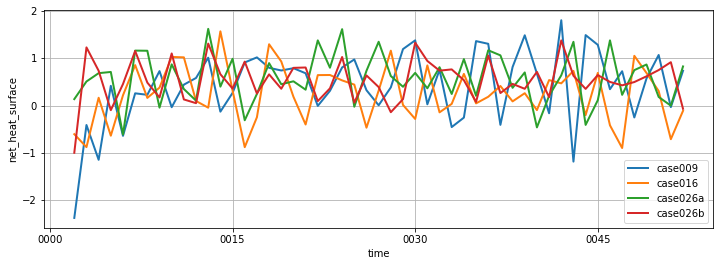

In [29]:
%matplotlib inline

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,4))
for i in range(ncases):
  net_heat_surface_list[i].plot(ax=ax, label=label[i], lw=2)

ax.legend()
ax.grid()

In [30]:
frc_list[i].net_heat_surface.isel(time=1).weighted(grd_xr.area_t).mean().values

array(8.602915, dtype=float32)

## Check annual heat budget SUM from CPL table

In [31]:
# add case005 
# cam6 instead of cam_dev
# and cice5 instead of cice6
#label.append('case005')
#outdir.append('/glade/scratch/hannay/archive/b.cesm3_cam041_mom.B1850WcMOM.ne30_L58_t061.cice5.cam6.005/ocn/hist/')

In [32]:
# add case007 
# cam_dev
# cice6
label.append('case007')
outdir.append('/glade/scratch/hannay/archive/b.cesm3_cam058_mom.B1850WscMOM.ne30_L58_t061.007/ocn/hist/')

In [33]:
outdir

['/glade/scratch/hannay/archive/b.cesm3_cam058_mom_c.B1850WscMOM.ne30_L58_t061.009/ocn/hist/',
 '/glade/scratch/hannay/archive/b.cesm3_cam058_mom_e.B1850MOM.f09_L32_t061.cam6_cice5.016/ocn/hist/',
 '/glade/scratch/hannay/archive/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026a/ocn/hist/',
 '/glade/scratch/hannay/archive/b.cesm3_cam058_mom_e.B1850WscMOM.ne30_L58_t061.camdev_cice5.026b/ocn/hist/',
 '/glade/scratch/hannay/archive/b.cesm3_cam058_mom.B1850WscMOM.ne30_L58_t061.007/ocn/hist/']

In [34]:
def get_budget(path):
  import pandas as pd
  header=["ATM",'LND',"OCN","ICE_N","ICE_S","SUM"]
  cmd1 = "zgrep  -A 17 'NET HEAT BUDGET (W/m2): period =   annual' "
  cmd2 ="diags.log.* | grep 'SUM' | grep -v 'atm'> tmp.txt"
  os.system(cmd1+path+cmd2)
  df = pd.read_csv('tmp.txt',delim_whitespace=True,
                   usecols=[2,3,5,6,7,9], names=header)
  os.system('rm tmp.txt')
  return df

In [35]:
heat_budget_list = []
for p, i in zip(outdir,range(len(outdir))):
    #print(p)
    p = p+'../../logs/'
    
    heat_budget_list.append(get_budget(p))

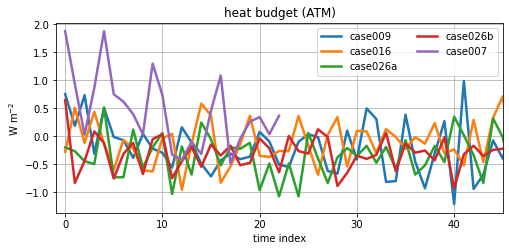

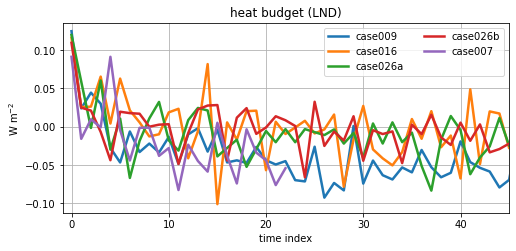

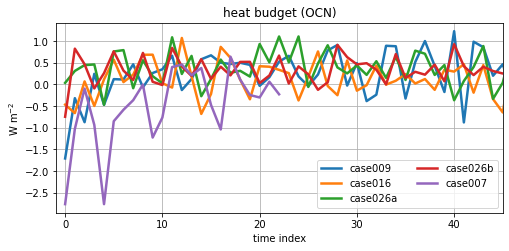

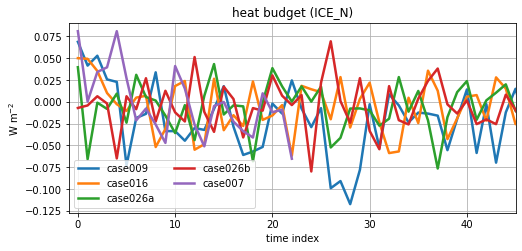

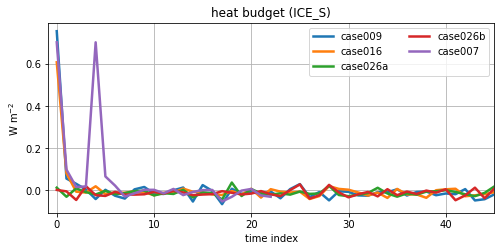

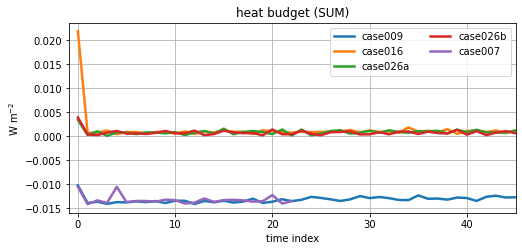

In [36]:
for k in heat_budget_list[0].keys():
  fig, ax = plt.subplots(figsize=(8,3.5))
  for l, heat in zip(label,heat_budget_list):
    heat[k].plot(ax=ax,lw=2.5, label=l)
    ax.set_title('heat budget ({})'.format(k))
    ax.grid()
    ax.set_ylabel(r'W m$^{-2}$')
    ax.set_xlabel('time index')
    ax.set_xlim(-0.9,45)
  ax.legend(ncol=2);
  fname='PNG/CPL_heat_budget_comparison_{}.png'.format(k)
  plt.savefig(fname)